<a href="https://colab.research.google.com/github/geek0075/hse/blob/main/experiment_showing_if_regularization_mitigates_overfitting_in_case_of_abundantly_large_number_of_neurons_apr_3_2021_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment showing if regularization mitigates overfitting in case of abundantly large number of neurons

### Import python modules

In [ ]:
# import python modules
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import sklearn
import sklearn.datasets
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import tqdm
tqdm.monitor_interval = 0

### Define neural network in pure numpy code

#### Neural network classes

Here we define classes for building a sequential neural network using numpy only in python. We define classes for 5 types of layers as required:

1. Layer. This is the base neural network layer. Every other type of neural network layer must inherit from Layer.
2. ReLU Layer. This layer type implements the rectified linear unit (ReLU) activation function.
3. Sigmoid Layer. This layer type implements the sigmoid activation function.
4. Dense Layer. This layer type implements a linear combination of its input with a set of trainable weights.
   1. The Dense layer implements several weight initialization methods:
      1. Zero initialization. All weights are initialized to zero.
      2. Random initialization. All weights are initialized to random numbers from a normal distribution.
      3. Small random initialization. All weights are initialized to small random numbers from a normal
         distribution.
      4. Large random initialization. All weights are initialized to large random numbers from a normal
         distribution.
      5. Xavier initialization. All weights are initialized according to the 'xavier' algorithm.
      6. He initialization. All weights are initialized according to the 'he' algorithm.
   2. The Dense layer implements several weight optimization methods:
      1. Gradient descent. The gradient descent algorithm.
      2. Momentum. The gradient descent algorithm with momentum.
      3. RMSProps. The gradient descent algorithm with rms props.
   3. The Dense layer implements regularization by weight decay using L2 regularization algorithm.
5. BatchNorm Layer. This layer implements the batch normalization algorithm.

In [ ]:
# Neural Network in Pure Numpy Code
# Base Layer Class
class Layer:
    """
    A building block. Each layer is capable of performing two things:
    
    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        pass
    
    def forward(self, input, training=True):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        
        To compute loss gradients w.r.t input, you need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, you already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If your layer has parameters (e.g. dense layer), you also need to update them here using d loss / d layer
        """
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

# ReLU Layer Class
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass

    def forward(self, input, training=True):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        # <your code. Try np.maximum>
        return np.maximum(0, input)

    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output*relu_grad

# Sigmoid Layer Class
class Sigmoid(Layer):
    def __init__(self):
        """Sigmoid layer simply applies elementwise sigmoid to all inputs"""
        pass
    
    def forward(self, input, training=True):
        return 1 / (1 + np.exp(-input))
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. Sigmoid input"""
        sigmoid_grad = np.exp(input) / np.power(np.exp(input) + 1, 2)
        return grad_output * sigmoid_grad
    
# Dense Layer Class
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1, reg_param=0, init='small_random', optim='sgd', beta1=0.9, beta2=0.999, epsilon=1e-8, seed=1000):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate
        self.reg_param = reg_param
        
        # initialize weights with small random numbers. We use normal initialization, 
        # but surely there is something better. Try this once you got it working: http://bit.ly/2vTlmaJ
        np.random.seed(seed)
        if init == 'zero':
            self.weights = np.zeros((input_units, output_units))
        elif init == 'random':
            self.weights = np.random.randn(input_units, output_units)
        elif init == 'small_random':
            self.weights = np.random.randn(input_units, output_units) * 0.01
        elif init == 'large_random':
            self.weights = np.random.randn(input_units, output_units) * 10
        elif init == 'xavier':
            self.weights = np.random.randn(input_units, output_units) * np.sqrt(1. / output_units)
        elif init == 'he':
            self.weights = np.random.randn(input_units, output_units) * np.sqrt(2. / output_units)
        self.biases = np.zeros(output_units, dtype=np.float64)

        self.optim = optim
        if optim == 'momentum':
            self.beta1 = beta1
            self.v = {}
            self.v['dW'] = np.zeros((input_units, output_units), dtype=np.float64)
            self.v['db'] = np.zeros(output_units, dtype=np.float64)
        elif optim == 'rmsprop':
            self.beta2 = beta2
            self.epsilon = epsilon
            self.s = {}
            self.s['dW'] = np.zeros((input_units, output_units), dtype=np.float64)
            self.s['db'] = np.zeros(output_units, dtype=np.float64)

    def forward(self,input,training=True):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return np.dot(input, self.weights) + self.biases
    
    def backward(self,input,grad_output):
        
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, self.weights.T)
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = np.sum(grad_output, axis=0)
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        # Here we perform a stochastic gradient descent step. 
        # Later on, you can try replacing that with something better.
        if self.optim == 'sgd':
            self.weights = (1 - self.learning_rate * 2 * self.reg_param) * self.weights - self.learning_rate * grad_weights
            self.biases = self.biases - self.learning_rate * grad_biases
        elif self.optim == 'momentum':
            self.v['dW'] = self.beta1 * self.v['dW'] + (1 - self.beta1) * grad_weights
            self.v['db'] = self.beta1 * self.v['db'] + (1 - self.beta1) * grad_biases
            self.weights = (1 - self.learning_rate * 2 * self.reg_param) * self.weights - (self.learning_rate * self.v['dW'])
            self.biases = self.biases - (self.learning_rate * self.v['db'])
        elif self.optim == 'rmsprop':
            self.s['dW'] = self.beta2 * self.s['dW'] + (1 - self.beta2) * np.power(grad_weights, 2, dtype=np.float64)
            self.s['db'] = self.beta2 * self.s['db'] + (1 - self.beta2) * np.power(grad_biases, 2, dtype=np.float64)
            self.weights = (1 - self.learning_rate * 2 * self.reg_param) * self.weights - self.learning_rate * (grad_weights / (np.sqrt(self.s['dW'], dtype=np.float64) + self.epsilon))
            self.biases = self.biases - self.learning_rate * (grad_biases / (np.sqrt(self.s['db'], dtype=np.float64) + self.epsilon))

        return grad_input
    
# Batch Normalization Layer Class
class BatchNorm(Layer):
    def __init__(self, output_units, learning_rate=0.1, momentum=0.9, optim='sgd', epsilon=1e-8):
        """
        A batch normalization layer is a layer which performs batch normalization:
        """
        self.gamma = np.ones(output_units)
        self.beta = np.zeros(output_units)
        self.moving_mean = np.zeros(output_units)
        self.moving_var = np.zeros(output_units)
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.optim = optim
        if optim == 'momentum':
            self.v = {}
            self.v['dgamma'] = np.zeros(output_units)
            self.v['dbeta'] = np.zeros(output_units)
        self.epsilon = epsilon

    def forward(self, input, training=True):
        """
        Perform a batch normalization:
        """
        if training == True:
            mean = np.mean(input, axis=0)
            var = np.mean(np.power(input - mean, 2), axis=0)
            x_hat = (input - mean) / np.sqrt(var + self.epsilon)
            self.moving_mean = self.momentum * self.moving_mean + (1.0 - self.momentum) * mean
            self.moving_var = self.momentum * self.moving_var + (1.0 - self.momentum) * var
        else:
            x_hat = (input - self.moving_mean) / np.sqrt(self.moving_var + self.epsilon)
        output = self.gamma * x_hat + self.beta
        return output
    
    def backward(self, input, grad_output):
        
        n, _ = input.shape
        mean = np.mean(input, axis=0)
        var = np.mean(np.power(input - mean, 2), axis=0)
        x_hat = (input - mean) / np.sqrt(var + self.epsilon)
        dx_hat = grad_output * self.gamma
        dvar = np.sum(dx_hat, axis=0) * (input - mean) * ((-(1/2)) * (var + self.epsilon)**(-(3/2)))
        dmean = (np.sum(dx_hat, axis=0) * (-(1 / np.sqrt(var + self.epsilon)))) + (dvar * (np.sum(-2 * (input - mean), axis=0) / n))
        dx = dx_hat * (1 / np.sqrt(var + self.epsilon)) + (dvar * (np.sum(2 * (input - mean), axis=0) / n)) + (dmean * (1 / n))
        dgamma = np.sum(grad_output * x_hat, axis=0)
        dbeta = np.sum(grad_output, axis=0)
        if self.optim == 'sgd':
            self.gamma = self.gamma - self.learning_rate * dgamma
            self.beta = self.beta - self.learning_rate * dbeta
        elif self.optim == 'momentum':
            self.v['dgamma'] = self.momentum * self.v['dgamma'] + (1 - self.momentum) * dgamma
            self.v['dbeta'] = self.momentum * self.v['dbeta'] + (1 - self.momentum) * dbeta
            self.gamma = self.gamma - self.learning_rate * self.v['dgamma']
            self.beta = self.beta - self.learning_rate * self.v['dbeta']
        return dx

### Define utility functions for working with the pure numpy neural network

#### Neural network architecture functions.

All the work here is done with a predefined neural network architecture that is defined here in the function 'get_network'. We have defined an sequential deep learning architecture with 8 Dense layers as follows:

1. Layer 1. Dense layer with 10 neurons, batch normalization and relu activation.
2. Layer 2. Dense layer with 20 neurons, batch normalization and relu activation.
3. Layer 3. Dense layer with 30 neurons, batch normalization and relu activation.
4. Layer 4. Dense layer with 40 neurons, batch normalization and relu activation.
5. Layer 5. Dense layer with 30 neurons, batch normalization and relu activation.
6. Layer 6. Dense layer with 20 neurons, batch normalization and relu activation.
7. Layer 7. Dense layer with 10 neurons, batch normalization and relu activation.
8. Layer 8. Dense layer with 2 neurons and linear activation.

In total the neural network architecture used for the experiments here have 162 neurons across all 8 layers. So there are plenty of neurons to learn complex functions and overfit small datasets.

We will show here in our experiments how regularization can mitigate this overfitting.

In [ ]:
# Compute Cross Entropy Loss
def softmax_crossentropy_with_logits(logits, reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)), reference_answers]
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits), axis=-1))
    return xentropy

# Compute the Gradient of the Cross Entropy Loss wrt Network Output
def grad_softmax_crossentropy_with_logits(logits, reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)), reference_answers] = 1
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1, keepdims=True)
    return (- ones_for_answers + softmax) / logits.shape[0]

# Run the forward computation defined by your Network
def forward(network, X, training=True):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X
    # forward can return X and a cache which is 
    # added to activations as a Tuple
    for layer in network:
        X = layer.forward(X, training=training)
        activations.append(X)
        
    assert len(activations) == len(network)
    return activations

# Use your Network for Prediction
def predict(network, X):
    """
    Compute network predictions.
    """
    logits = forward(network,X, training=False)[-1]
    return logits.argmax(axis=-1)

# Train your Network on Example Data
def train(network, X, y):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    Then you can run layer.backward going from last to first layer.
    
    After you called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X, training=True)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient 
    # todo: loss needs to be adjusted for regularization
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # <your code: propagate gradients through the network>
    for i in range(len(network)-1, -1, -1):
        loss_grad = network[i].backward(layer_inputs[i], loss_grad)
        
    return np.mean(loss)

# Create a Predefined Network Architecture
def get_network(input_dim, learning_rate, reg_param):
    # xavier initialization, optimization=momentum
    network = []
    network.append(Dense(input_dim, 10, learning_rate=learning_rate, reg_param=reg_param, init='xavier', optim='momentum', seed=1000))
    network.append(BatchNorm(10))
    network.append(ReLU())
    network.append(Dense(10, 20, learning_rate=learning_rate, reg_param=reg_param, init='xavier', optim='momentum', seed=1001))
    network.append(BatchNorm(20))
    network.append(ReLU())
    network.append(Dense(20, 30, learning_rate=learning_rate, reg_param=reg_param, init='xavier', optim='momentum', seed=1002))
    network.append(BatchNorm(30))
    network.append(ReLU())
    network.append(Dense(30, 40, learning_rate=learning_rate, reg_param=reg_param, init='xavier', optim='momentum', seed=1003))
    network.append(BatchNorm(40))
    network.append(ReLU())
    network.append(Dense(40, 30, learning_rate=learning_rate, reg_param=reg_param, init='xavier', optim='momentum', seed=1004))
    network.append(BatchNorm(30))
    network.append(ReLU())
    network.append(Dense(30, 20, learning_rate=learning_rate, reg_param=reg_param, init='xavier', optim='momentum', seed=1005))
    network.append(BatchNorm(20))
    network.append(ReLU())
    network.append(Dense(20, 10, learning_rate=learning_rate, reg_param=reg_param, init='xavier', optim='momentum', seed=1006))
    network.append(BatchNorm(10))
    network.append(ReLU())
    network.append(Dense(10, 2, learning_rate=learning_rate, reg_param=reg_param, init='xavier', optim='momentum', seed=1007))
    return network

# Run Network Training Loop in Epochs
def run_epochs(network, T, X_train, y_train, X_val, y_val):
    train_log = []
    val_log = []
    for epoch in tqdm_notebook_failsafe(range(T)):
        train(network, X_train, y_train)
        if epoch % 1000 == 0:
            train_acc = np.mean(predict(network, X_train)==y_train)
            val_acc = np.mean(predict(network, X_val)==y_val)
            train_log.append(train_acc)
            val_log.append(val_acc)
            # clear_output()
            # print("Epoch",epoch)
            # print("Train accuracy:", train_acc)
            # print("Val accuracy:", val_acc)
    train_acc = np.mean(predict(network, X_train)==y_train)
    val_acc = np.mean(predict(network, X_val)==y_val)
    train_log.append(train_acc)
    val_log.append(val_acc)
    clear_output()
    print("Train accuracy:", train_acc)
    print("Val accuracy:", val_acc)
    plt.plot(train_log, label='train accuracy')
    plt.plot(val_log, label='val accuracy')
    plt.legend(loc='best')
    plt.title('Training accuracy vs. Validation accuracy')
    plt.grid()
    plt.show()

### Dataset loading and visualization functions

The experiments described here use 2 datasets from 'sklearn.datasets' to train and validate our neural network model. Both datasets are for classification between two classes of points data.

#### The moons dataset

A description of this dataset can be read online at the following urls:

https://scikit-learn.org/stable/datasets/sample_generators.html
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html#sklearn.datasets.make_moons

The function 'load_dataset_moons()' loads the moons dataset.

#### The circles dataset

A description of this dataset can be read online at the following urls:

https://scikit-learn.org/stable/datasets/sample_generators.html
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html#sklearn.datasets.make_circles

The function 'load_dataset_circles()' loads the circles dataset.

#### Visualizing learnt decision boundaries

The neural network classifies data by learning a decision boundary (line, curve, etc) that separates one class from the other. The function 'plot_decision_boundary()' takes a trained network and displays its learnt decision boundary in a plot.

In [ ]:
def plot_decision_boundary(network, title, X, y, X_train, y_train, X_test, y_test):
    x_min, x_max = X_train[:, 0].min() - .5, X_train[:, 0].max() + .5
    y_min, y_max = X_train[:, 1].min() - .5, X_train[:, 1].max() + .5
    h = .01  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    Z = predict(network, np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    # Plot the training points
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
    axes = plt.gca()
    axes.set_xlim(xx.min(), xx.max())
    axes.set_ylim(yy.min(), yy.max())
    axes.set_xticks(())
    axes.set_yticks(())
    axes.set_title(title)
    
def load_dataset_moons():
    X, y = sklearn.datasets.make_moons(n_samples=400, noise=.3, random_state=1001)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1002)
    x_min, x_max = X_train[:, 0].min() - .5, X_train[:, 0].max() + .5
    y_min, y_max = X_train[:, 1].min() - .5, X_train[:, 1].max() + .5
    h = .01  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    plt.title("Moons Input Dataset")
    # Plot the training points
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
    axes = plt.gca()
    axes.set_xlim([xx.min(), xx.max()])
    axes.set_ylim([yy.min(), yy.max()])
    axes.set_xticks(())
    axes.set_yticks(())
    return X, y, X_train, y_train, X_test, y_test

def load_dataset_circles():
    X, y = sklearn.datasets.make_circles(n_samples=400, noise=0.2, factor=0.5, random_state=1001)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1002)
    x_min, x_max = X_train[:, 0].min() - .5, X_train[:, 0].max() + .5
    y_min, y_max = X_train[:, 1].min() - .5, X_train[:, 1].max() + .5
    h = .01  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    plt.title("Circles Input Dataset")
    # Plot the training points
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
    axes = plt.gca()
    axes.set_xlim([xx.min(), xx.max()])
    axes.set_ylim([yy.min(), yy.max()])
    axes.set_xticks(())
    axes.set_yticks(())
    return X, y, X_train, y_train, X_test, y_test

# Class to fix tqdm package on Jupyter Notebooks
class SimpleTqdm():
    def __init__(self, iterable=None, total=None, **kwargs):
        self.iterable = list(iterable) if iterable is not None else None
        self.total = len(self.iterable) if self.iterable is not None else total
        assert self.iterable is not None or self.total is not None
        self.current_step = 0
        self.print_frequency = max(self.total // 50, 1)
        self.desc = ""

    def set_description_str(self, desc):
        self.desc = desc

    def set_description(self, desc):
        self.desc = desc

    def update(self, steps):
        last_print_step = (self.current_step // self.print_frequency) * self.print_frequency
        i = 1
        while last_print_step + i * self.print_frequency <= self.current_step + steps:
            print("*", end='')
            i += 1
        self.current_step += steps

    def close(self):
        print("\n" + self.desc)

    def __iter__(self):
        assert self.iterable is not None
        self.index = 0
        return self

    def __next__(self):
        if self.index < self.total:
            element = self.iterable[self.index]
            self.update(1)
            self.index += 1
            return element
        else:
            self.close()
            raise StopIteration

def tqdm_notebook_failsafe(*args, **kwargs):
    try:
        return tqdm.tqdm_notebook(*args, **kwargs)
    except:
        # tqdm is broken on Google Colab
        return SimpleTqdm(*args, **kwargs)

# The experiments proper

## Experiment 1: overfitting a deep learning neural network on the sklearn moons dataset

This experiment shows how a deep learning neural network can overfit to the training dataset when the model is trained for 30,000 epochs without regularization. The sklearn moons dataset is available here: 

https://scikit-learn.org/stable/datasets/sample_generators.html
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html#sklearn.datasets.make_moons

A sample of 400 data points is drawn from that dataset and divided into 300 examples for training and 100 examples for validation.

The resulting train/validation dataset is then used to train and test a single large deep learning neural network with plenty of neurons in two situations:

1. The neural network is trained for 30,000 epochs with no regularization
2. The neural network is trained for 30,000 epochs with 0.1 regularization

You will observe (from data and graphs) how the neural network overfits to the training dataset when trained without regularization and how it performs better on the dataset when trained with regularization to mitigate (reduce) overfitting and increase generalization.

### Load and visualize the sklearn moons dataset

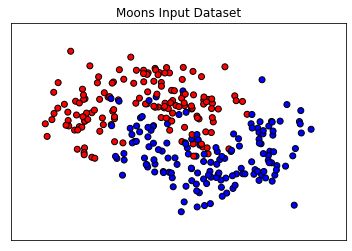

In [ ]:
X_moon, y_moon, X_moon_train, y_moon_train, X_moon_val, y_moon_val = load_dataset_moons()

### Train and test neural network on moons dataset with no regularization

Observe how the network overfits the training dataset by achieving an accuracy of 1.0 on the training dataset. Also you observe that the network achieves an accuracy of 0.91 on the validation dataset. This accuracy on the validation dataset can be increased if regularization is applied during training to prevent the network from overfitting to the training dataset.

Also notice how the decision boundary follows every nuance of the training dataset - even creating 'islands' around noisy data in order to achieve a perfect 1.0 fit on the training dataset.

Train accuracy: 1.0
Val accuracy: 0.91


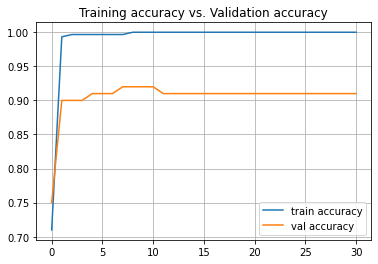

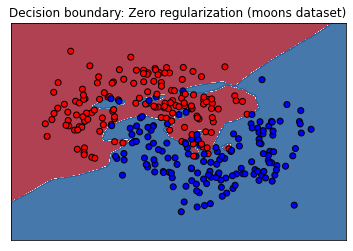

In [ ]:
# create network with ample neurons and zero regularization
network = get_network(X_moon_train.shape[1], learning_rate=0.3, reg_param=0.0)
# train network for 30000 epochs on Moon dataset
run_epochs(network, 30000, X_moon_train, y_moon_train, X_moon_val, y_moon_val)
# plot decision boundary illustrating extensive overfitting without regularization
plot_decision_boundary(network, 'Decision boundary: Zero regularization (moons dataset)', X_moon, y_moon, X_moon_train, y_moon_train, X_moon_val, y_moon_val)

### Train and test neural network on moons dataset with 0.1 regularization

Observe how the application of regularization (with a factor of 0.1) mitigates overfitting. The 0.1 regularization factor was found via a grid search. What it does is to prevent the network from fitting to noisy data on the training dataset. When the network does not fit to noise on the training dataset it achieves less accuracy on the training dataset. However it compensates for this by achieving higher accuracy on the validation dataset. That is it generalizes better.

So now the prior training dataset accuracy of 1.0 has been pushed down to 0.93 while the prior validation dataset accuracy of 0.91 has been pushed up to 0.96!

Also notice how the decision boundary no longer follows every nuance of the training dataset. It also no longer creates 'islands' around noisy data on the training dataset.

Train accuracy: 0.92
Val accuracy: 0.94


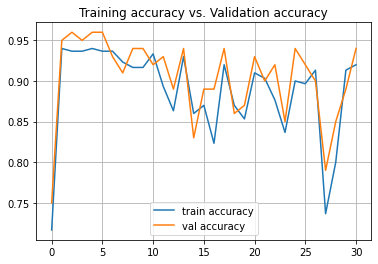

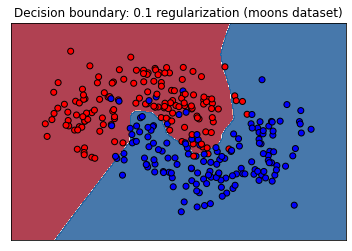

In [ ]:
# create network with ample neurons and 0.1 regularization
network = get_network(X_moon_train.shape[1], learning_rate=0.3, reg_param=0.1)
# train network for 30000 epochs on Moon dataset
run_epochs(network, 30000, X_moon_train, y_moon_train, X_moon_val, y_moon_val)
plot_decision_boundary(network, 'Decision boundary: 0.1 regularization (moons dataset)', X_moon, y_moon, X_moon_train, y_moon_train, X_moon_val, y_moon_val)

### Experiment 1: Observations

#### Scenario: Zero Regularization

The model achieves an accuracy of 1.0 on the training dataset and 0.91 on the validation dataset. This is the scenario without regularization.

#### Scenario: 0.1 Regularization

The model achieves a reduced accuracy of 0.93 on the training dataset as a result of regularization, and a increased accuracy of 0.96 on the validation dataset.

#### Conclusion

We can safely conclude from experiment 1 that regularization does mitigate overfitting because we see a decrease in accuracy on the training set (less of a fit on the training dataset) accompanied by an increase in accuracy on the validation set (greater generalization of the model to the population).

An intuition for the overfitting can be gained by studying the decision boundary plots accompanying each result. You can see how the plot has islands (islets) and seems to meander deeply in order to correctly classify the training set. On the other hand, the decision boundary plot with regularization is smoother (less jaggy) as it generalizes more.

## Experiment 2: overfitting a deep learning neural network on the sklearn circles dataset

This experiment shows how a deep learning neural network can overfit to the training dataset when the model is trained for 30,000 epochs without regularization. The sklearn circles dataset is available here: 

https://scikit-learn.org/stable/datasets/sample_generators.html
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html#sklearn.datasets.make_circles

A sample of 400 data points is drawn from that dataset and divided into 300 examples for training and 100 examples for validation.

The resulting train/validation dataset is then used to train and test a single large deep learning neural network with plenty of neurons in two situations:

1. The neural network is trained for 30,000 epochs with no regularization
2. The neural network is trained for 30,000 epochs with 0.6 regularization

You will observe (from data and graphs) how the neural network overfits to the training dataset when trained without regularization and how it performs better on the dataset when trained with regularization to mitigate (reduce) overfitting and increase generalization.

### Load and visualize the sklearn circles dataset

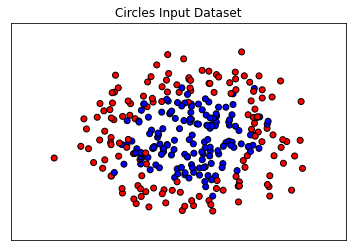

In [ ]:
X_circle, y_circle, X_circle_train, y_circle_train, X_circle_val, y_circle_val = load_dataset_circles()

### Train and test neural network on circles dataset with no regularization

Observe how the network overfits the training dataset by achieving an accuracy of 1.0 on the training dataset. Also you observe that the network achieves an accuracy of 0.83 on the validation dataset. This accuracy on the validation dataset can be increased if regularization is applied during training to prevent the network from overfitting to the training dataset.

Also notice how the decision boundary follows every nuance of the training dataset - even creating 'islands' around noisy data in order to achieve a perfect 1.0 fit on the training dataset.

Train accuracy: 1.0
Val accuracy: 0.83


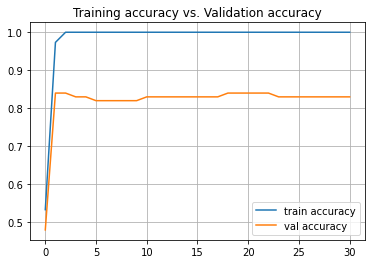

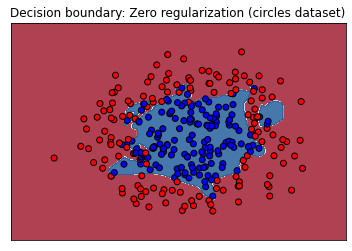

In [ ]:
# create network with ample neurons and zero regularization
network = get_network(X_circle_train.shape[1], learning_rate=0.1, reg_param=0.0)
# train network for 30000 epochs on Circles dataset
run_epochs(network, 30000, X_circle_train, y_circle_train, X_circle_val, y_circle_val)
# plot decision boundary illustrating extensive overfitting without regularization
plot_decision_boundary(network, 'Decision boundary: Zero regularization (circles dataset)', X_circle, y_circle, X_circle_train, y_circle_train, X_circle_val, y_circle_val)

### Train and test neural network on circles dataset with 0.6 regularization

Observe how the application of regularization (with a factor of 0.6) mitigates overfitting. The 0.6 regularization factor was found via a grid search. What it does is to prevent the network from fitting to noisy data on the training dataset. When the network does not fit to noise on the training dataset it achieves less accuracy on the training dataset. However it compensates for this by achieving higher accuracy on the validation dataset. That is it generalizes better.

So now the prior training dataset accuracy of 1.0 has been pushed down to 0.89 while the prior validation dataset accuracy of 0.83 has been pushed up to 0.88!

Also notice how the decision boundary no longer follows every nuance of the training dataset. It also no longer creates 'islands' around noisy data on the training dataset.

In [ ]:
# create network with ample neurons and 0.6 regularization
network = get_network(X_circle_train.shape[1], learning_rate=0.1, reg_param=0.6)
# train network for 30000 epochs on Circles dataset
run_epochs(network, 30000, X_circle_train, y_circle_train, X_circle_val, y_circle_val)
plot_decision_boundary(network, 'Decision boundary: 0.6 regularization (circles dataset)', X_circle, y_circle, X_circle_train, y_circle_train, X_circle_val, y_circle_val)

### Experiment 2: Observations

#### Scenario: Zero Regularization

The model achieves an accuracy of 1.0 on the training dataset and 0.83 on the validation dataset. This is the scenario without regularization.

#### Scenario: 0.6 Regularization

The model achieves a reduced accuracy of 0.89 on the training dataset as a result of regularization, and a increased accuracy of 0.88 on the validation dataset.

#### Conclusion

We can safely conclude from experiment 2 that regularization does mitigate overfitting because we see a decrease in accuracy on the training set (less of a fit on the training dataset) accompanied by an increase in accuracy on the validation set (greater generalization of the model to the population).
